In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

from CliqueFinder import CliqueFinder

import matplotlib.pyplot as plt
import seaborn as sns

seed = 5
threshold = 0.6

## First look

In [2]:
boston_dataset = load_boston(return_X_y=False)

In [3]:
boston_data = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston_target =  boston_dataset.target

In [4]:
#print(boston_dataset['DESCR'])

In [5]:
boston_data.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [6]:
boston_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


## Train test split

In [7]:
train_data, val_data, train_target, val_target = train_test_split(boston_data, 
                                                                boston_target,
                                                                test_size = 0.2, 
                                                                random_state=seed)

# EDA

## outliers remove

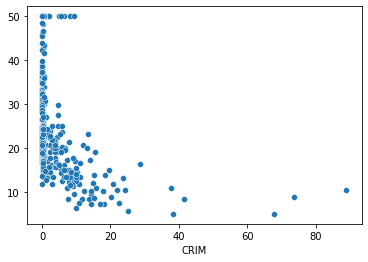

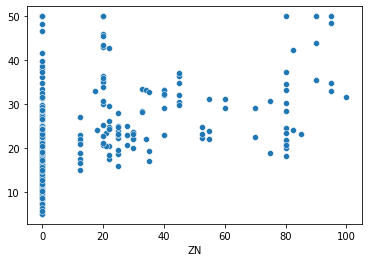

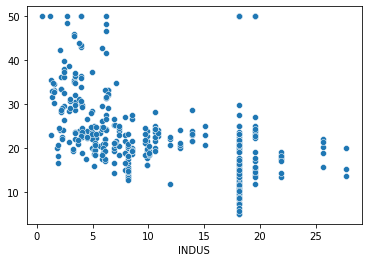

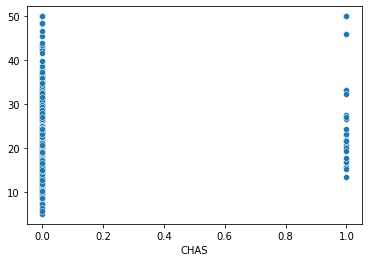

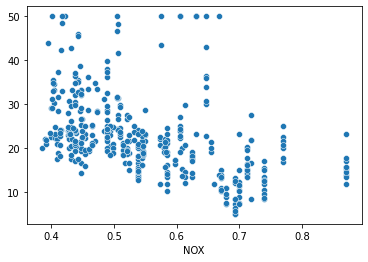

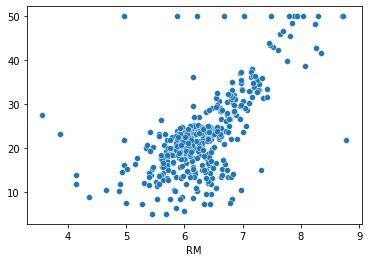

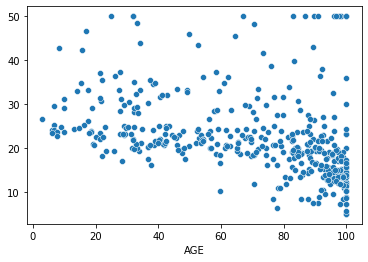

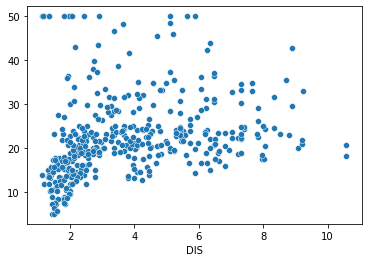

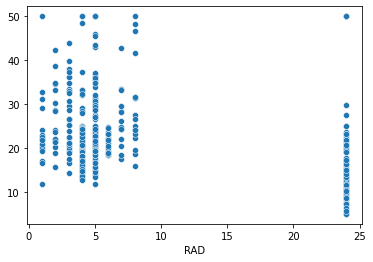

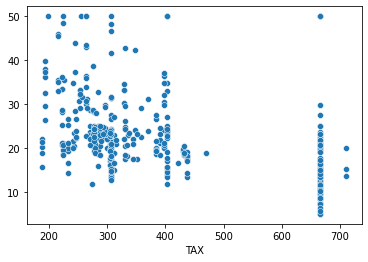

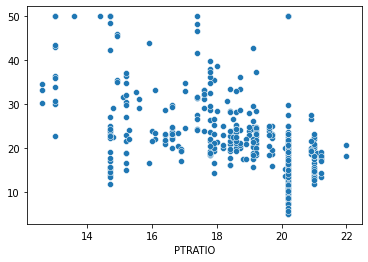

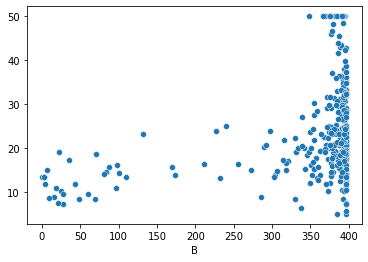

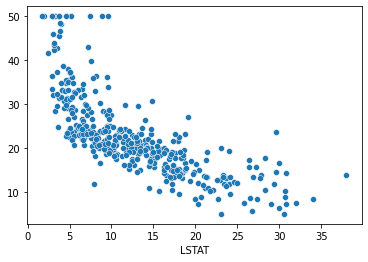

In [8]:
for feature_obj in train_data.select_dtypes(include=['int64','float64']).columns:
    sns.scatterplot(x=train_data[feature_obj], y=train_target)
    plt.show()

In [9]:
valid_train = train_data['CRIM'] < 60
valid_validation = val_data['CRIM'] < 60
train_data = train_data[valid_train]
train_target = train_target[valid_train]
val_data = val_data[valid_validation]
val_target = val_target[valid_validation]

## Feature elimination

In [10]:
pval = 0.01
corr_threshold = 0.2
excluded_features = []
for feature in train_data.columns:
    result = stats.spearmanr(boston_data[feature], boston_target)
    if np.abs(result[1]) > pval or np.abs(result[0]) < corr_threshold:
        excluded_features.append(feature)

boston_data = boston_data.drop(columns=excluded_features)

In [11]:
excluded_features

['CHAS', 'B']

In [12]:
corr_matrix = train_data.corr(method ='spearman')
# spearman pearson

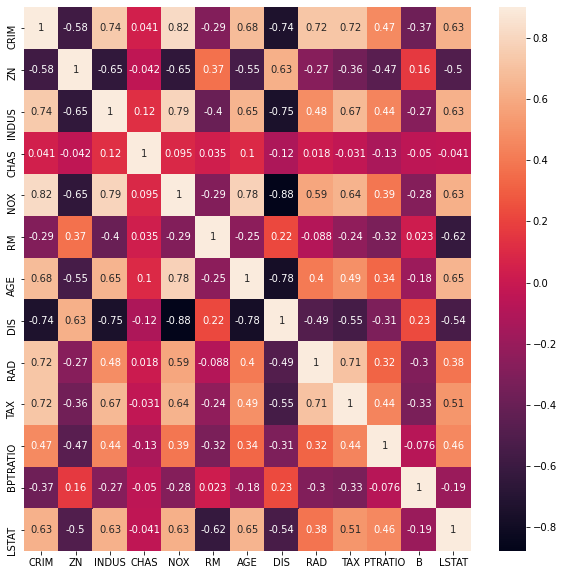

In [13]:
f, ax1 = plt.subplots(figsize=(10,10)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, annot = True);

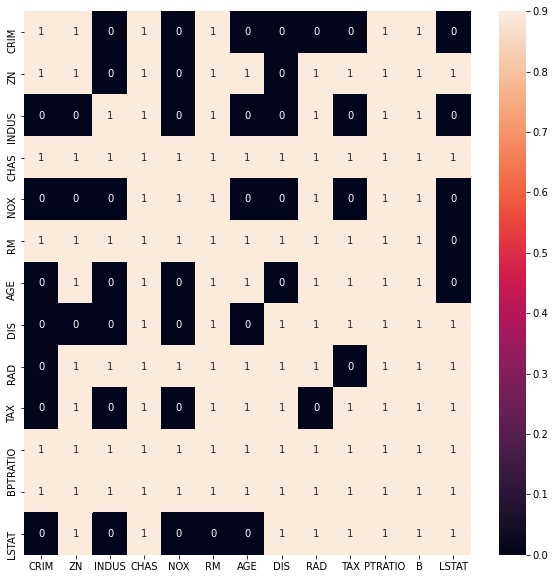

In [28]:
corr_matrix_th = corr_matrix.applymap(lambda x: 0 if (np.abs(x) > threshold) else 1)
n = len(corr_matrix_th)
for i in range(n):
    corr_matrix_th.iloc[i,i]=1
f, ax1 = plt.subplots(figsize=(10,10)) 
ax1=sns.heatmap(corr_matrix_th,vmax = 0.9, annot = True);

In [16]:
#corr_func = lambda x,y: stats.pearsonr(x,y)[0]
corr_func = lambda x,y: stats.spearmanr(x,y)[0] 

In [17]:
CliqFinderObj = CliqueFinder(corr_matrix, train_data, train_target)

In [18]:
CliqFinderObj.fit(feature_target_corr_func=corr_func, threshold=threshold)

In [19]:
best_features_subset = CliqFinderObj.get_best_clique()
features_to_exclude = CliqFinderObj.get_out_of_clique_features()

In [20]:
#new_boston_data = boston_data[best_features_subset]
new_train_data = train_data.drop(columns=features_to_exclude)
new_val_data = val_data.drop(columns=features_to_exclude)
new_train_data.shape

(401, 7)

In [21]:
new_corr_matrix = new_train_data.corr()

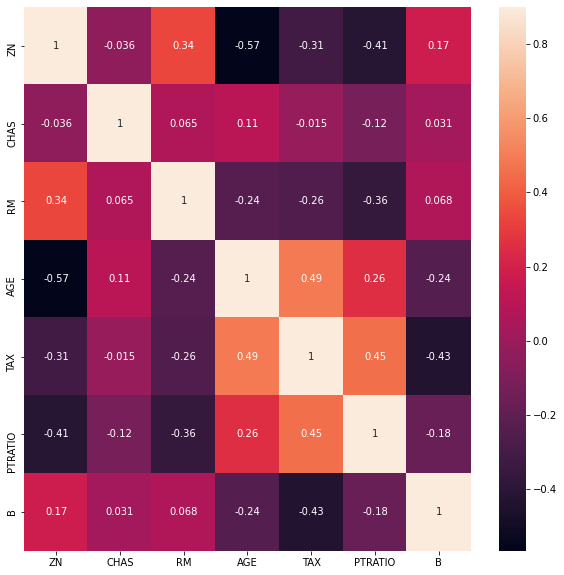

In [22]:
f, ax1 = plt.subplots(figsize=(10,10)) 
ax1=sns.heatmap(new_corr_matrix,vmax = 0.9, annot = True);

## Pipeline Setup & ML model train

In [23]:
pipeline = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('Estimator', LinearRegression())
])

train_target = np.log(train_target)

In [24]:
pipeline.fit(new_train_data, train_target)

Pipeline(steps=[('scaler', StandardScaler()),
                ('Estimator', LinearRegression())])

In [25]:
prediction_value = pipeline.predict(new_val_data)
prediction_value = np.exp(prediction_value)
rmse = mean_squared_error(val_target, prediction_value, squared=False)
r2_score_value = r2_score(val_target, prediction_value)
print("RMSE: {} R2_Score: {}".format(rmse, r2_score_value))

RMSE: 4.03642727563095 R2_Score: 0.791902668483753


## Post-Hoc analysis

In [26]:
error = prediction_value - val_target

<AxesSubplot:ylabel='Count'>

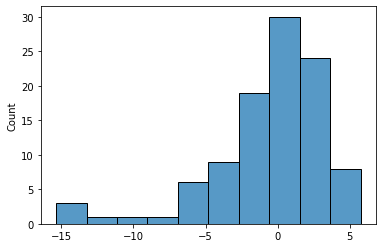

In [27]:
sns.histplot(error, bins=10)